<a href="https://colab.research.google.com/github/GreihMurray/NLP-5/blob/master/anything_goes_3_Murray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import string
from string import digits
import re
from sklearn.utils import shuffle
from keras_preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Input, Dense,Embedding
from keras.models import Model,load_model
from keras.utils import plot_model
from keras.preprocessing.text import one_hot
from keras.preprocessing.text import Tokenizer
from keras.models import model_from_json
import pickle as pkl
import numpy as np
from tqdm import tqdm
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu

In [2]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
def read_train_file(file_name):
    all_data = []
    descript = 'Reading ' + file_name

    f = open(file_name, 'r', encoding='utf-8')
    full_text = f.read()

    cur_sent = []

    for line in tqdm(full_text.split('\n'), desc=descript):
        if line == '<s>':
            cur_sent = []
            continue
        if line in '()':
            continue
        if line == '</s>':
            all_data.append(cur_sent)
            continue
        else:
            cur_sent.append(line.lower())

    return all_data

In [4]:
def read_all_train(source_file, targ_file):
    all_data = []
    descript = 'Reading files'
    clean_punct = '-.,\''

    clean_source = []
    clean_targ = []

    source_data = read_train_file(source_file)
    target_data = read_train_file(targ_file)

    for i in tqdm(range(0, len(source_data)), desc='Cleaning data'):
        clean_source.append(' '.join(source_data[i]))
        clean_targ.append(' '.join(target_data[i]))


    return clean_source, clean_targ

elow code from https://medium.com/analytics-vidhya/neural-machine-translation-using-simple-seq2seq-517b5ce1ae0f

B

In [5]:
s, t = read_all_train('/content/gdrive/MyDrive/Colab_Notebooks/NLP/translation/train-source.txt', '/content/gdrive/MyDrive/Colab_Notebooks/NLP/translation/train-target.txt')
print(s[:5])
print(t[:5])

Reading /content/gdrive/MyDrive/Colab_Notebooks/NLP/translation/train-source.txt: 100%|██████████| 925535/925535 [00:00<00:00, 1406119.43it/s]
Reading /content/gdrive/MyDrive/Colab_Notebooks/NLP/translation/train-target.txt: 100%|██████████| 910805/910805 [00:00<00:00, 1956133.14it/s]
Cleaning data: 100%|██████████| 45171/45171 [00:00<00:00, 545335.22it/s]


['cinnte go leór , thiocfadh dóbhtha bás a fhagháil ar imeall an phuill udaí .', 'bhí sé follasach go rabh an poll sin ag foscladh ar an fhairrge ar dhóigh éigin , ná líonadh agus thráigheadh an t-uisce ann .', "d'fhéadfadh siad bás ' fhagháil ar a bhruach agus na cuirp imtheacht ar an lán mhara amach fríd an phluais .", 'thiocfadh dóbhtha fosta lámh a chur ina mbás féin , a ghabháil de léim isteach sa pholl ghalach a bhí i n-iarthar an dara taibhlidh - poll mar bhéadh coire de uisce ghalach ann .', "' na dhiaidh sin , bhí rud éigin do-chreidte agus leamh in gach teóir de'n bheirt ."]
['cinnte go leor , thiocfadh dóibh bás a fháil ar imeall an phoill úd .', 'bhí sé follasach go raibh an poll sin ag foscladh ar an fharraige ar dhóigh éigin , nó líonadh agus thráigheadh an t-uisce ann .', "d'fhéadfadh siad bás a fháil ar a bhruach agus na coirp a imeacht ar an lán mhara amach fríd an phluais .", "thiocfadh dóibh fosta lámh a chur ina mbás féin , a ghabháil de léim isteach sa pholl ghalac

In [6]:
language_data = pd.DataFrame(columns=['source','target'])
language_data['source'] = s
language_data['target'] = t

# saving to csv
language_data.to_csv('language_data.csv', index=False)

# loading data from csv
language_data = pd.read_csv('language_data.csv')

In [7]:

source_text = language_data['source'].values
target_text = language_data['target'].values

source_text[0], target_text[0]

#lowercasing the setences
source_text_ = [x.lower() for x in source_text]
target_text_ = [x.lower() for x in target_text]

# Text preprocessing
source_text_ = [re.sub("'",'',x) for x in source_text_]
target_text_ = [re.sub("'",'',x) for x in target_text_]

# remove puntuation
def remove_punc(text_list):
  table = str.maketrans('', '', string.punctuation)
  removed_punc_text = []
  for sent in text_list:
    sentance = [w.translate(table) for w in sent.split(' ')]
    removed_punc_text.append(' '.join(sentance))
  return removed_punc_text
source_text_ = remove_punc(source_text_)
target_text_ = remove_punc(target_text_)

# removing the digits from english sentances
remove_digits = str.maketrans('', '', digits)
removed_digits_text = []
for sent in source_text_:
  sentance = [w.translate(remove_digits) for w in sent.split(' ')]
  removed_digits_text.append(' '.join(sentance))
source_text_ = removed_digits_text

# removing the digits from the marathi sentances
target_text_ = [re.sub("[२३०८१५७९४६]","",x) for x in target_text_]
target_text_ = [re.sub("[\u200d]","",x) for x in target_text_]

# removing the stating and ending whitespaces
source_text_ = [x.strip() for x in source_text_]
target_text_ = [x.strip() for x in target_text_]

In [8]:
source_text_ = [x.strip() for x in source_text_]
target_text_ = [x.strip() for x in target_text_]

In [9]:
target_text_ = ["start " + x + " end" for x in target_text_]

In [10]:

X = source_text_
Y = target_text_

#Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size = 0.1)

print(len(X_train))

print(len(y_train))

print(len(X_test))

print(len(y_test))

40653
40653
4518
4518


In [11]:
# preparing data for the word embedding
def Max_length(data):
  max_length_ = max([len(x.split(' ')) for x in data])
  return max_length_

#Training data
max_length_source = Max_length(X_train)
max_lenght_target = Max_length(y_train)

#Test data
max_length_source_test = Max_length(X_test)
max_lenght_target_test = Max_length(y_test)

In [12]:
max_lenght_target, max_length_source

(222, 230)

In [13]:
def tokenizer_(text_data):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(text_data)
  return tokenizer

tokenizer_input = tokenizer_(X_train)
vocab_size_input = len(tokenizer_input.word_index) + 1
tokenizer_target = tokenizer_(y_train)
vocab_size_target = len(tokenizer_target.word_index) + 1

In [14]:
vocab_size_input,vocab_size_target

(27955, 23965)

In [15]:
with open('tokenizer_input.pkl','wb') as f:
  pkl.dump(tokenizer_input,f)

with open('tokenizer_target.pkl','wb') as f:
  pkl.dump(tokenizer_target,f)
pkl.dump(tokenizer_input, open('tokenizer_input.pkl', 'wb'))
pkl.dump(tokenizer_target, open('tokenizer_target.pkl', 'wb'))

In [16]:
def generator_batch(X= X_train,Y=y_train, batch_size=128):
  while True:
    for j in range(0, len(X), batch_size):
      encoder_data_input = np.zeros((batch_size,max_length_source),dtype='float32') #metrix of batch_size*max_length_english
      decoder_data_input = np.zeros((batch_size,max_lenght_target),dtype='float32') #metrix of batch_size*max_length_marathi
      decoder_target_input = np.zeros((batch_size,max_lenght_target,vocab_size_target),dtype='float32') # 3d array one hot encoder decoder target data
      for i, (input_text,target_text) in enumerate(zip(X[j:j+batch_size],Y[j:j+batch_size])):
        for t, word in enumerate(input_text.split()):
          encoder_data_input[i,t] = tokenizer_input.word_index[word] # Here we are storing the encoder 
                                                                     #seq in row here padding is done automaticaly as 
                                                                     #we have defined col as max_lenght
        for t, word in enumerate(target_text.split()):
          # if word == 'START_':
          #   word = 'start'
          # elif word == 'END_':
          #   word = 'end'
          decoder_data_input[i,t] = tokenizer_target.word_index[word] # same for the decoder sequence
          if t>0:
            decoder_target_input[i,t-1,tokenizer_target.word_index[word]] = 1 #target is one timestep ahead of decoder input because it does not have 'start tag'
      # print(encoder_data_input.shape())
      yield ([encoder_data_input,decoder_data_input],decoder_target_input)

In [17]:
latent_dim = 50
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None,),name="encoder_inputs")
emb_layer_encoder = Embedding(vocab_size_input,latent_dim, mask_zero=True)(encoder_inputs)
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(emb_layer_encoder)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,),name="decoder_inputs")
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
emb_layer_decoder = Embedding(vocab_size_target,latent_dim, mask_zero=True)(decoder_inputs)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(emb_layer_decoder, initial_state=encoder_states)
decoder_dense = Dense(vocab_size_target, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [18]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

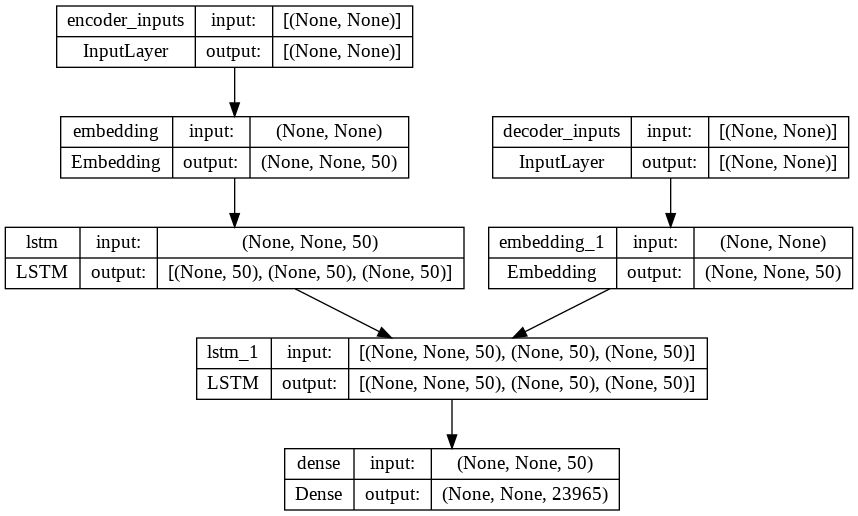

In [19]:
plot_model(model, to_file='train_model.png', show_shapes=True)

In [47]:
train_samples = len(X_train)
val_samples = len(X_test)
batch_size = 25
epochs = 30

In [ ]:
model.fit_generator(generator = generator_batch(X_train, y_train, batch_size = batch_size),
                    steps_per_epoch = train_samples//batch_size,
                    epochs=epochs)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/30
1626/1626 [==============================] - 413s 254ms/step - loss: 0.2930 - accuracy: 0.3890
Epoch 2/30
1626/1626 [==============================] - 413s 254ms/step - loss: 0.2900 - accuracy: 0.3941
Epoch 3/30
1626/1626 [==============================] - 413s 254ms/step - loss: 0.2873 - accuracy: 0.3992
Epoch 4/30
1626/1626 [==============================] - 412s 254ms/step - loss: 0.2847 - accuracy: 0.4038
Epoch 5/30
1626/1626 [==============================] - 412s 253ms/step - loss: 0.2823 - accuracy: 0.4079
Epoch 6/30
1626/1626 [==============================] - 412s 253ms/step - loss: 0.2798 - accuracy: 0.4119
Epoch 7/30
1626/1626 [==============================] - 397s 244ms/step - loss: 0.2775 - accuracy: 0.4156
Epoch 8/30
1626/1626 [==============================] - 396s 243ms/step - loss: 0.2753 - accuracy: 0.4190
Epoch 9/30
1626/1626 [==============================] - 396s 244ms/step - loss: 0.2733 - accuracy: 0.4225
Epoch 10/30
1626/1626 [=======================

In [ ]:
model_json = model.to_json()
with open("/content/gdrive/MyDrive/Colab_Notebooks/NLP/translation/model_2.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("/content/gdrive/MyDrive/Colab_Notebooks/NLP/translation/model_weight_5.h5")
print("Saved model to disk")

In [ ]:
# loading the model architecture and asigning the weights
json_file = open('/content/gdrive/MyDrive/Colab_Notebooks/NLP/translation/model_2.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model_loaded = model_from_json(loaded_model_json)
# load weights into new model
model_loaded.load_weights("/content/gdrive/MyDrive/Colab_Notebooks/NLP/translation/model_weight_5.h5")

In [ ]:
latent_dim = 50
#inference encoder
encoder_inputs_inf = model_loaded.input[0] #Trained encoder input layer
encoder_outputs_inf, inf_state_h, inf_state_c = model_loaded.layers[4].output # retoring the encoder lstm output and states
encoder_inf_states = [inf_state_h,inf_state_c]
encoder_model = Model(encoder_inputs_inf,encoder_inf_states)


#inference decoder
# The following tensor will store the state of the previous timestep in the "starting the encoder final time step"
decoder_state_h_input = Input(shape=(latent_dim,)) #becase during training we have set the lstm unit to be of 50
decoder_state_c_input = Input(shape=(latent_dim,))
decoder_state_input = [decoder_state_h_input,decoder_state_c_input]

# # inference decoder input
decoder_input_inf = model_loaded.input[1] #Trained decoder input layer
# decoder_input_inf._name='decoder_input'
decoder_emb_inf = model_loaded.layers[3](decoder_input_inf)
decoder_lstm_inf = model_loaded.layers[5]
decoder_output_inf, decoder_state_h_inf, decoder_state_c_inf = decoder_lstm_inf(decoder_emb_inf, initial_state =decoder_state_input)
decoder_state_inf = [decoder_state_h_inf,decoder_state_c_inf]
#inference dense layer
dense_inf = model_loaded.layers[6]
decoder_output_final = dense_inf(decoder_output_inf)# A dense softmax layer to generate prob dist. over the target vocabulary

decoder_model = Model([decoder_input_inf]+decoder_state_input,[decoder_output_final]+decoder_state_inf)

In [ ]:
#inference decoder
# The following tensor will store the state of the previous timestep in the "starting the encoder final time step"
decoder_state_h_input = Input(shape=(latent_dim,)) #becase during training we have set the lstm unit to be of 50
decoder_state_c_input = Input(shape=(latent_dim,))
decoder_state_input = [decoder_state_h_input,decoder_state_c_input]

In [ ]:
# inference decoder input
decoder_input_inf = model_loaded.input[1] #Trained decoder input layer
# decoder_input_inf._name='decoder_input'
decoder_emb_inf = model_loaded.layers[3](decoder_input_inf)
decoder_lstm_inf = model_loaded.layers[5]
decoder_output_inf, decoder_state_h_inf, decoder_state_c_inf = decoder_lstm_inf(decoder_emb_inf, initial_state =decoder_state_input)
decoder_state_inf = [decoder_state_h_inf,decoder_state_c_inf]
#inference dense layer
dense_inf = model_loaded.layers[6]
decoder_output_final = dense_inf(decoder_output_inf)# A dense softmax layer to generate prob dist. over the target vocabulary

decoder_model = Model([decoder_input_inf]+decoder_state_input,[decoder_output_final]+decoder_state_inf)

In [ ]:
reverse_word_map_input = dict(map(reversed, tokenizer_input.word_index.items()))
reverse_word_map_target = dict(map(reversed, tokenizer_target.word_index.items()))

In [ ]:
# Code to predct the input sentences translation
def decode_seq(input_seq):
  # print("input_seq=>",input_seq)
  state_values_encoder = encoder_model.predict(input_seq)
  # intialize the target seq with start tag
  target_seq = np.zeros((1,1))
  target_seq[0, 0] = tokenizer_target.word_index['start']
  # print("target_seq:=>",target_seq)
  stop_condition = False
  decoder_sentance = ''
  # print("Beforee the while loop")
  while not stop_condition:
    sample_word , decoder_h,decoder_c= decoder_model.predict([target_seq] + state_values_encoder)
    # print("sample_word: =>",sample_word)
    sample_word_index = np.argmax(sample_word[0,-1,:])
    # print("sample_word_index: ",sample_word_index)
    decoder_word = reverse_word_map_target[sample_word_index]
    decoder_sentance += ' '+ decoder_word
    # print("decoded word:=>",decoder_word)
    # print(len(decoder_sentance))
    # print("len(decoder_sentance) > 70: ",len(decoder_sentance) > 70)
    # print('decoder_word == "end"',decoder_word == 'end')
    # print(decoder_word == 'end' or len(decoder_sentance) > 70)
    # stop condition for the while loop
    if (decoder_word == 'end' or 
        len(decoder_sentance) > 70):
        stop_condition = True
        # print("from if condition")
    # target_seq = np.zeros((1,1))
    target_seq[0, 0] = sample_word_index
    # print(target_seq)
    state_values_encoder = [decoder_h,decoder_c]
  return decoder_sentance

In [ ]:
for i in range(30):
  sentance = X_test[i]
  original_target = y_test[i]
  input_seq = tokenizer_input.texts_to_sequences([sentance])
  pad_sequence = pad_sequences(input_seq, maxlen= 30,padding='post')
  # print('input_sequence =>',input_seq)
  # print("pad_seq=>",pad_sequence)
  predicted_target = decode_seq(pad_sequence)
  print("Test sentance: ",i+1)
  print("sentance: ",sentance)
  print("origianl translate:",original_target[6:-4])
  print("predicted Translate:",predicted_target[:-4])
  print(original_target[6:-4].split(' '))
  print(predicted_target[:-4].split(' '))
  print(sentence_bleu([original_target[6:-4].split(' ')], predicted_target[:-4].split(' ')))
  print("=="*50)